In [1]:
%load_ext autoreload
%autoreload 2
import jax
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from copy import deepcopy


import pyForwardFolding as pyFF

In [2]:
24831360.0 / (np.pi*1E7) * 365

288.4984592016887

In [ ]:
data = pd.read_parquet("/home/wecapstor3/capn/capn104h/KM3NeT_Analysis/datasets/NNMFit_dataframe/KM3NeT_dataframe/KM3NeT_ARCA21_galactic_weighted_without_muons.parquet")
print("len data ",len(data))
data = data[data["bdt_score"] > 0.5]
print("len data ",len(data))

smallest = jnp.finfo(jnp.float64).smallest_normal
smallest = 1E-40
data = data.loc[(data.fluxless_weight > smallest) & (data.mceq_conv_H4a_SIBYLL23c > smallest), :]


input_variables = {
    "true_energy": jnp.asarray(data.MCPrimaryEnergy, dtype=jnp.float64),
    "log10_reco_energy": jnp.log10(jnp.asarray(data.Energy, dtype=jnp.float64)),
    "cos_reco_zenith": jnp.cos(jnp.asarray(data.dir_z, dtype=jnp.float64)),
    "baseline_weight": jnp.asarray(data.fluxless_weight, dtype=jnp.float64),
    "conv_weight": jnp.asarray(data.mceq_conv_H4a_SIBYLL23c, dtype=jnp.float64),
    "prompt_weight": jnp.asarray(data.mceq_pr_H4a_SIBYLL23c, dtype=jnp.float64),
    "conv_weight_alt": jnp.asarray(data.mceq_conv_GST4_SIBYLL23c, dtype=jnp.float64),
    "prompt_weight_alt": jnp.asarray(data.mceq_pr_GST4_SIBYLL23c, dtype=jnp.float64),
    "bdt_score": jnp.asarray(data.bdt_score, dtype=jnp.float64),
    # "e_scaling": jnp.asarray(data.e_scaling),
    # "e_smearing": jnp.asarray(data.e_smearing),
}

dataset = {"ds1": input_variables}

median_energy = pyFF.backend.backend.weighted_median(dataset["ds1"]["true_energy"], dataset["ds1"]["conv_weight"])
dataset["ds1"]["median_energy"] = median_energy



len data  11141007
len data  6333636


[]

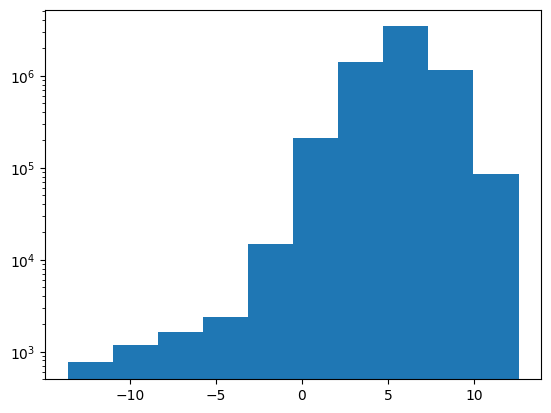

In [17]:
plt.hist(np.log10(input_variables["baseline_weight"]))
plt.semilogy()

In [18]:
ana = pyFF.config.analysis_from_config("test_ARCA21.yaml")
lik = pyFF.likelihood.PoissonLikelihood(ana)

In [23]:
model_parameters = {
    "astro_norm": 1.0,
    "astro_index": 2.37,
    "atmo_norm": 1.0,
    "delta_gamma": 0.0,
    "prompt_norm": 0.0,
    "lambda_int": 1.0,
    "bdt_score_cut": 0.9,
}

bound_config = {
    "astro_norm": (0, np.inf),
    "prompt_norm": (0., np.inf),
    "astro_index": (0, 5.0),
    "delta_gamma": (-1, 1),
    "atmo_norm": (0., np.inf),
    "lambda_int": (0., 1),
    "bdt_score_cut": (0, 1),
}

In [24]:
hist, hist_ssq = ana.evaluate(dataset, model_parameters)
obs = hist # asimov

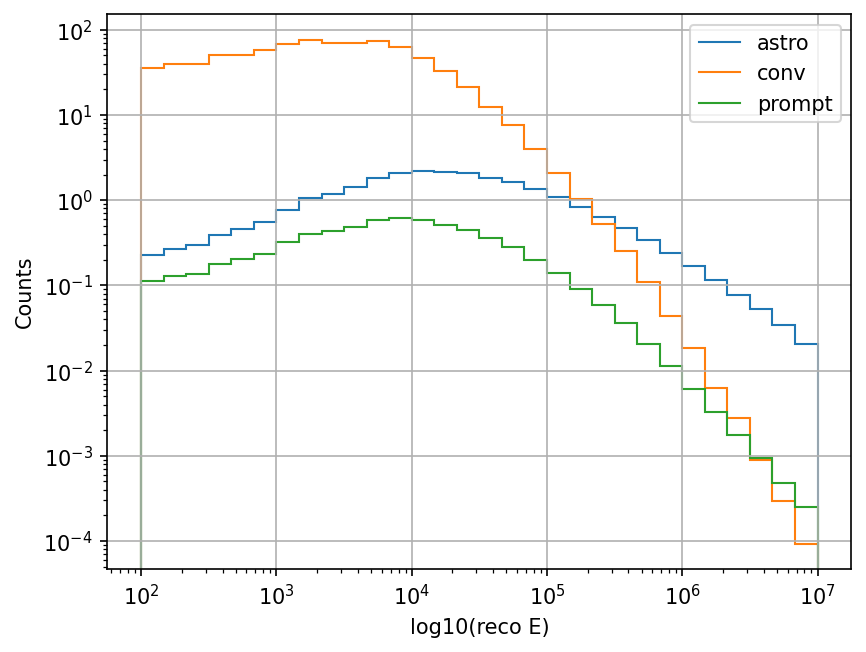

In [25]:
plt.figure(dpi=150)
det = "det1"
mparams = deepcopy(model_parameters)
mparams["astro_norm"] = 1
mparams["atmo_norm"] = 0
mparams["prompt_norm"] = 0
hist, hist_ssq = ana.evaluate(dataset, mparams)
binning = ana.expectations[det].binning
hsum = hist[det].reshape(binning.hist_dims).sum(axis=1)
plt.stairs(edges = 10**binning.bin_edges[0], values=hsum, label = "astro",)

mparams = deepcopy(model_parameters)
mparams["astro_norm"] = 0
mparams["atmo_norm"] = 1
mparams["prompt_norm"] = 0
hist, hist_ssq = ana.evaluate(dataset, mparams)
binning = ana.expectations[det].binning
hsum = hist[det].reshape(binning.hist_dims).sum(axis=1)
plt.stairs(edges = 10**binning.bin_edges[0], values=hsum, label = "conv",)
    
mparams = deepcopy(model_parameters)
mparams["astro_norm"] = 0
mparams["atmo_norm"] = 0
mparams["prompt_norm"] = 1
hist, hist_ssq = ana.evaluate(dataset, mparams)
binning = ana.expectations[det].binning
hsum = hist[det].reshape(binning.hist_dims).sum(axis=1)
plt.stairs(edges = 10**binning.bin_edges[0], values=hsum, label = "prompt",)

plt.yscale("log")
plt.xscale("log")
   
plt.xlabel("log10(reco E)")
plt.ylabel("Counts")
plt.legend()
plt.grid()


In [10]:
lh = lik.llh(obs, dataset, model_parameters)
lh_jit = jax.jit(lik.llh)

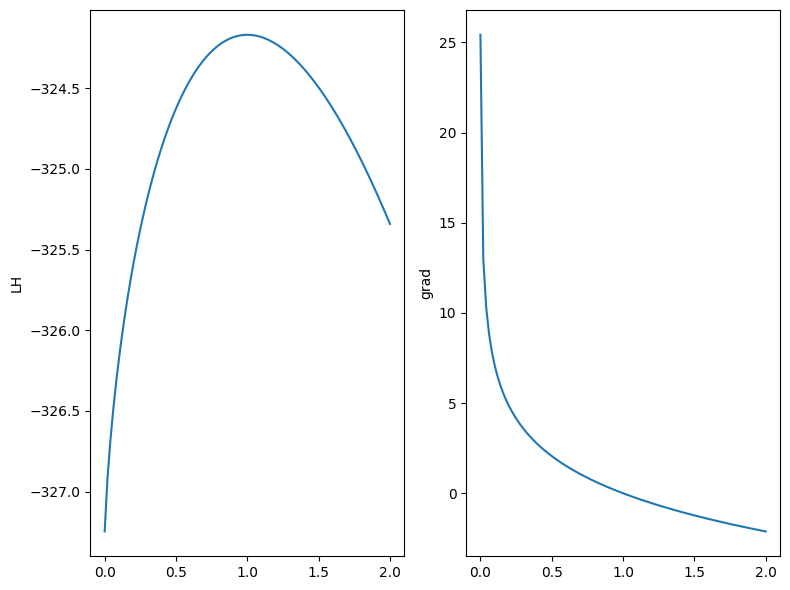

In [11]:
def eval_for_par(par_val, par_dict):
    par_dict["astro_norm"]= par_val
    lh = lik.llh(obs, dataset, par_dict)
    return lh

val_grad = jax.jit(jax.value_and_grad(eval_for_par, 0) )

scan_vals = jnp.linspace(0, 2, 100)
lhs, grads = jax.vmap(val_grad, in_axes=(0, None))(scan_vals, model_parameters)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6), sharex=True)
ax1.plot(scan_vals, lhs)
ax1.set_ylabel("LH")
ax2.plot(scan_vals, grads)
ax2.set_ylabel("grad")
plt.tight_layout()


In [26]:
grad = jax.grad(lik.llh, argnums=2)(obs, dataset, model_parameters)

In [49]:
def jac_for_index(ix):
    return jax.jacobian(lambda d, p: ana.evaluate(d, p)[0]["det1"][ix], argnums=1)(dataset, model_parameters)

f = jax.jit(jac_for_index)

In [52]:
f((20, 15))

{'astro_index': Array(-0.04547198, dtype=float64, weak_type=True),
 'astro_norm': Array(0.05917661, dtype=float64, weak_type=True),
 'atmo_norm': Array(0.04344829, dtype=float64, weak_type=True),
 'bdt_score_cut': Array(0., dtype=float64, weak_type=True),
 'delta_gamma': Array(-0.14051192, dtype=float64, weak_type=True),
 'lambda_int': Array(-0.01414957, dtype=float64, weak_type=True),
 'prompt_norm': Array(0.00568523, dtype=float64, weak_type=True)}

In [37]:
res = ana.evaluate(dataset, model_parameters)[0]["det1"][0, 0]

In [32]:
type(res)

tuple

In [36]:
mini = pyFF.minimizer.ScipyMinimizer(lik, obs, dataset, bound_config, model_parameters, {}, {}, tol=1e-14)
res = mini.minimize()
res

(  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
   success: True
    status: 0
       fun: 324.16889455049306
         x: [ 1.000e+00  0.000e+00  2.370e+00  1.000e+00  0.000e+00
              1.000e+00]
       nit: 0
       jac: [ 2.440e-16  2.764e-16  2.838e-17 -1.658e-15 -1.920e-17
             -1.331e-16]
      nfev: 1
      njev: 1
  hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>,
 {'lambda_int': np.float64(1.0),
  'delta_gamma': np.float64(0.0),
  'astro_index': np.float64(2.37),
  'atmo_norm': np.float64(1.0),
  'prompt_norm': np.float64(0.0),
  'astro_norm': np.float64(1.0)},
 324.16889455049306)

In [37]:
mini = pyFF.minimizer.ScipyMinimizer(lik, obs, dataset, bound_config, model_parameters, {}, {"astro_norm": 0}, tol=1e-18)
res = mini.minimize()
res

(  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
   success: True
    status: 0
       fun: 324.7767012641991
         x: [ 1.000e+00  1.376e-03  2.370e+00  9.659e-01  8.262e+00]
       nit: 24
       jac: [-2.894e-01 -8.332e-07  0.000e+00  6.382e-07  2.616e-08]
      nfev: 39
      njev: 39
  hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>,
 {'lambda_int': np.float64(1.0),
  'delta_gamma': np.float64(0.0013755967008470668),
  'astro_index': np.float64(2.37),
  'atmo_norm': np.float64(0.9658506351044693),
  'prompt_norm': np.float64(8.2622874559221),
  'astro_norm': 0},
 324.7767012641991)

In [41]:
mini = pyFF.minimizer.ScipyMinimizer(lik, obs, dataset, bound_config, model_parameters, {}, {"astro_norm": 0.0001}, tol=1e-16)
res = mini.minimize()
res

(  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
   success: True
    status: 0
       fun: 324.4515535114512
         x: [ 1.000e+00  9.550e-04  3.793e-01  9.729e-01  7.234e+00]
       nit: 45
       jac: [-1.013e-01 -5.504e-08  2.262e-08 -9.792e-08 -2.050e-09]
      nfev: 79
      njev: 79
  hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>,
 {'lambda_int': np.float64(1.0),
  'delta_gamma': np.float64(0.000955013317919259),
  'astro_index': np.float64(0.3793025784124482),
  'atmo_norm': np.float64(0.9729196095706756),
  'prompt_norm': np.float64(7.233597302995858),
  'astro_norm': 0.0001},
 324.4515535114512)

In [14]:
hist, hist_ssq = ana.evaluate(dataset, model_parameters)
obs = hist
astro_norms = np.linspace(0.001, 2, 40)
llhs = []
pars = []

for astro_norm in astro_norms:
    fixed_params = {"astro_norm": astro_norm}
    mini = pyFF.minimizer.ScipyMinimizer(lik, obs, dataset, bound_config, model_parameters, {}, fixed_params, tol=1e-18)
    
    res, xmin, fun = mini.minimize()
    llhs.append(fun)
    pars.append(xmin)

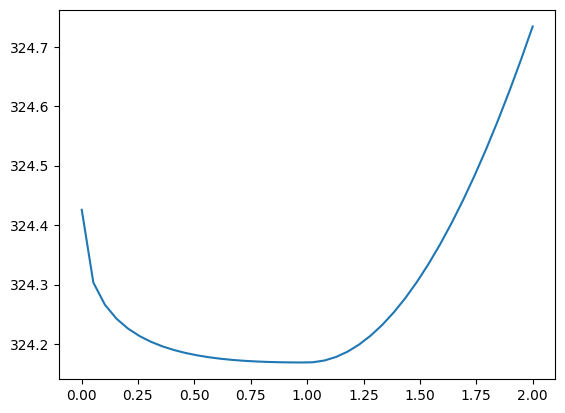

In [15]:
plt.plot(astro_norms, llhs, label= "pyForwardFolding")
#ax2 = plt.twinx()
#ax2.plot(astro_norms, [p["astro_index"] for p in pars])
#plt.semilogx()

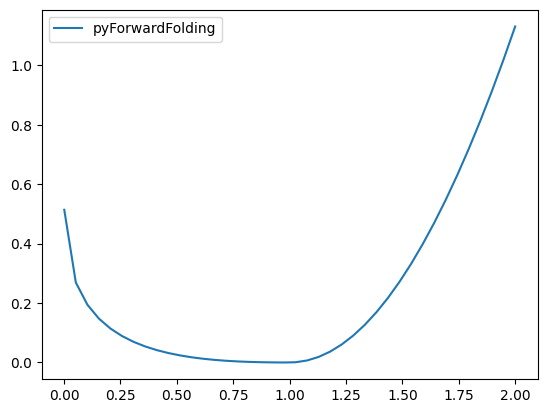

In [16]:
#ref_data = pd.read_hdf(os.path.join(data_path, "ScanResults.hdf"))
plt.plot(astro_norms, 2*(np.asarray(llhs) - min(llhs)), label= "pyForwardFolding")
#sort_by = np.argsort(ref_data.astro_norm.loc["astro_norm"])
#plt.plot(ref_data.astro_norm.loc["astro_norm"][sort_by], 2*ref_data.llh.loc["astro_norm"][sort_by], label = "NNMFit Reference")
plt.legend()
#plt.ylim(0, 36)

In [ ]:
print(astro_norms)

[0.         0.05128205 0.1025641  0.15384615 0.20512821 0.25641026
 0.30769231 0.35897436 0.41025641 0.46153846 0.51282051 0.56410256
 0.61538462 0.66666667 0.71794872 0.76923077 0.82051282 0.87179487
 0.92307692 0.97435897 1.02564103 1.07692308 1.12820513 1.17948718
 1.23076923 1.28205128 1.33333333 1.38461538 1.43589744 1.48717949
 1.53846154 1.58974359 1.64102564 1.69230769 1.74358974 1.79487179
 1.84615385 1.8974359  1.94871795 2.        ]


In [ ]:
print(2*(np.asarray(llhs) - min(llhs)))

[2.58643734e+00 6.28819901e-01 4.67380227e-01 3.63433618e-01
 2.87783045e-01 2.29610273e-01 1.83510246e-01 1.46325555e-01
 1.16019802e-01 9.11859141e-02 7.08006055e-02 5.40897490e-02
 4.04492366e-02 2.93958945e-02 2.05359372e-02 1.35441897e-02
 3.50660056e-02 1.72436566e-02 5.66592154e-03 9.87970509e-06
 0.00000000e+00 5.39827927e-03 1.59965343e-02 3.16105409e-02
 5.20748702e-02 6.34157390e-03 8.05510386e-03 9.79219414e-03
 1.15257200e-02 1.32345564e-02 1.49029906e-02 1.65201253e-02
 1.80793058e-02 1.95775614e-02 2.10150765e-02 2.23946673e-02
 2.37213327e-02 2.50018077e-02 2.62441315e-02 2.74573963e-02]


In [ ]:
hist, hist_ssq = ana.evaluate(dataset, model_parameters)
obs = hist

mini = pyFF.minimizer.MinuitMinimizer(lik, obs, dataset, bound_config, model_parameters, {}, {"astro_norm": 1.0,"prompt_norm":0})
res = mini.minimize()

Starting Minimization
Finished Minimization
best-fit llh:  281.39170853924725
----------------
best-fit parameters:
prompt_norm: 0
astro_index: 2.37
delta_gamma: 0.0
atmo_norm: 0.9999999999999999
lambda_int: 1.0
astro_norm: 1.0
----------------


In [ ]:
# Parameterbereiche
astro_norms = np.linspace(0, 3, 5)
gammas = np.linspace(2.0, 3.5, 5)

# Beobachtungen
hist, hist_ssq = ana.evaluate(dataset, model_parameters)
obs = hist

# 2D-Likelihood Array
llh_grid = np.zeros((len(gammas), len(astro_norms)))
pars_grid = np.empty((len(gammas), len(astro_norms)), dtype=object)

# Loop über Parameterpaare
for i, gamma in enumerate(gammas):
    for j, astro_norm in enumerate(astro_norms):
        print("ij",i,j)
        print(gamma)
        print(astro_norm)
        fixed_params = {"astro_norm": astro_norm,"astro_index": gamma}
        mini = pyFF.minimizer.ScipyMinimizer(lik, obs, dataset, bound_config, model_parameters, {}, fixed_params)
        res, xmin, fun = mini.minimize()
        llh_grid[i, j] = fun
        print(xmin)
        pars_grid[i, j] = xmin

ij 0 0
2.0
0.0
{'prompt_norm': np.float64(176.29513149879585), 'astro_index': np.float64(2.0), 'delta_gamma': np.float64(0.001926198972833675), 'atmo_norm': np.float64(0.9452951457030069), 'lambda_int': np.float64(0.9723160812525032), 'astro_norm': np.float64(0.0)}
ij 0 1
2.0
0.75
{'prompt_norm': np.float64(0.0001077437695749654), 'astro_index': np.float64(2.0), 'delta_gamma': np.float64(0.005791903603571052), 'atmo_norm': np.float64(0.986162357556366), 'lambda_int': np.float64(0.9452243242827023), 'astro_norm': np.float64(0.75)}
ij 0 2
2.0
1.5
{'prompt_norm': np.float64(1059.47901755157), 'astro_index': np.float64(2.0), 'delta_gamma': np.float64(0.0248716197481014), 'atmo_norm': np.float64(0.9436523442779299), 'lambda_int': np.float64(1.0040332055439136), 'astro_norm': np.float64(1.5)}
ij 0 3
2.0
2.25
{'prompt_norm': np.float64(1371.6797341230993), 'astro_index': np.float64(2.0), 'delta_gamma': np.float64(0.028617999334586915), 'atmo_norm': np.float64(0.9387160152901383), 'lambda_int'

In [ ]:
llh_grid

array([[282.6852698 , 281.77420884, 283.49688599, 286.02741602,
        289.05715887],
       [282.6852698 , 281.44581643, 281.4970086 , 281.98139524,
        282.75418592],
       [282.6852698 , 282.02306728, 281.64085446, 281.52568903,
        281.47309883],
       [282.6852698 , 283.36041626, 284.81416786, 288.55751715,
        294.09768248],
       [282.6852698 , 291.48492923, 337.16806095, 452.82455146,
        600.80093458]])

0.0


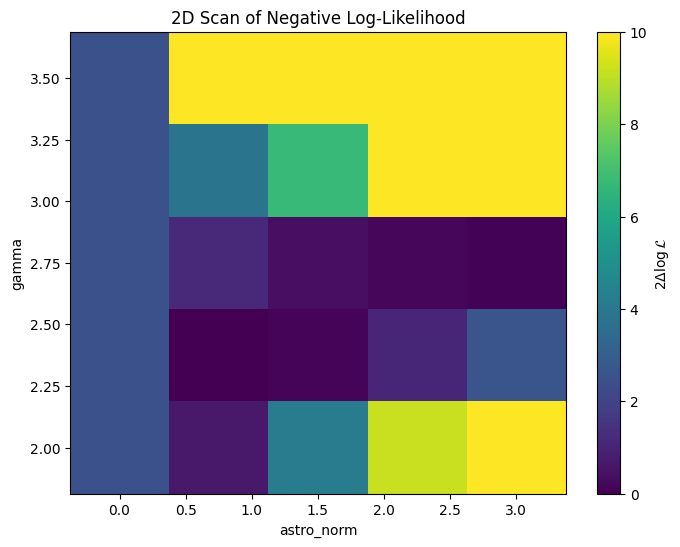

In [ ]:
llh_grid -= np.min(llh_grid)
delta_nll_grid = 2 * llh_grid

# Plot
plt.figure(figsize=(8, 6))
astro_grid, gamma_grid = np.meshgrid(astro_norms, gammas)

mesh = plt.pcolormesh(astro_grid, gamma_grid, delta_nll_grid,
                      shading='auto', cmap='viridis', vmax=10)

print(np.min(delta_nll_grid))
plt.colorbar(mesh, label=r"$2\Delta \log \mathcal{L}$")
plt.xlabel("astro_norm")
plt.ylabel("gamma")
plt.title("2D Scan of Negative Log-Likelihood")
plt.grid(False)
plt.show()